In [12]:
import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 

In [20]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

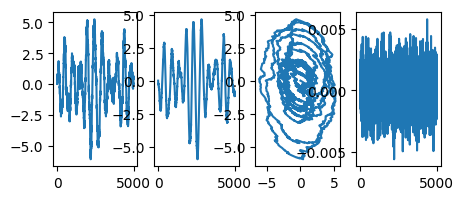

In [21]:
plt.figure(figsize=(5,2))
ax=plt.subplot(141)
ax.plot(x[:,0])
ax=plt.subplot(142)
ax.plot(x[:,1])
ax=plt.subplot(143)
ax.plot(x[:,0],x[:,1])
ax=plt.subplot(144)
ax.plot(dy[:,0])

In [22]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


In [612]:
class RecurrentCell(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentCell, self).__init__()
        
        self.dt, omega_0, self.simulation_params, self.xicov = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        self.omega_p = torch.nn.Parameter(data = torch.tensor([1e3],dtype=torch.float32, requires_grad=True))
        
        self.A = torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32)*self.omega_p 
        self.A+= torch.tensor(data = -0.5*gamma*np.eye(2), dtype=torch.float32)
       # self.A = torch.tensor(data=[[-gamma/2, self.omega_p],[-self.omega_p, -gamma/2]], dtype=torch.float32,requires_grad=True)
        self.proj_C = torch.tensor(data = [[1.,0.],[0.,0.]], dtype=torch.float32)
        self.C = self.proj_C*np.sqrt(4*eta*kappa)#*self.proj_C.clone().detach().requires_grad_(True), dtype=torch.float32)
        self.xicovC = self.xicov.matmul(self.C)

    def forward(self, dy, x):
        """
        input_data is dy
        hidden_state is x
        output dy_hat
        """
        dx = (self.A - self.xicovC).matmul(x)*dt + self.xicov.matmul(dy)# + self.omega_p
        dy_hat = self.C.matmul(x)*self.dt
        return torch.stack([x + dx, dy_hat])

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(inputs_cell=inputs_cell)

    def forward(self, dys):
        dys_hat = []
        xs_hat = [torch.tensor([0., 0.],dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [613]:
params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b = params
period = (2*np.pi/omega)
total_time = period*10
dt = period/500


gamma, omega, n, eta, kappa, b = params

A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
proj_C = np.array([[1.,0.],[0.,0.]])
C = np.sqrt(4*eta*kappa)*proj_C
D = np.diag([gamma*(n+0.5) + kappa]*2)
G = np.zeros((2,2))

Cov = solve_continuous_are(A-(G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
XiCov = Cov.dot(C) + G.T

inputs_cell = [dt, omega, params, torch.tensor(XiCov,dtype=torch.float32, requires_grad=True) ]

In [614]:
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)


In [615]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(2*dt)


In [617]:
rrn.zero_grad()
optimizer.zero_grad()
xs_hat, dys_hat = rrn(dys)
loss = log_lik(dys_hat, dys)

In [618]:
xs_hat, dys_hat = rrn(dys)
loss = log_lik(dys_hat, dys)

In [619]:
torch.autograd.grad(loss,rrn.RCell.omega_p)

(tensor([-0.0063]),)

Now I compute the second derivative...

In [620]:
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)

rrn.zero_grad()
xs_hat, dys_hat = rrn(dys)
loss = log_lik(dys_hat, dys)

In [621]:
torch.autograd.grad(torch.autograd.grad(loss,rrn.RCell.omega_p,create_graph=True),rrn.RCell.omega_p,create_graph=True)#,retain_graph=True)

(tensor([1.3326e-06], grad_fn=<ViewBackward0>),)

Okay, with this we get the gradient of the log-likelihood, then to get the fisher info we'd need to average this out over many trajectories and that's it.

One little detail i don't know how to do is to reset the RNN model so i can compute again the gradient without initializing a new RNN model...

# Training

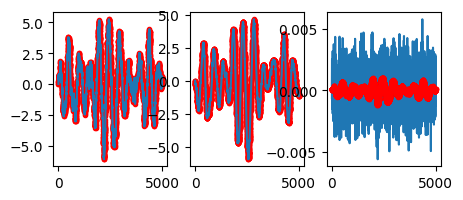

In [421]:
plt.figure(figsize=(5,2))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

In [422]:
def Cost(targets, inputs):
    return torch.sum((targets-rrn(inputs)[1])**2)/(2*dt)

def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(2*dt)

In [423]:
dev = torch.device("cpu")
optimizer = torch.optim.Adam(lr=0.01, params=rrn.parameters())

In [445]:
Recurrent = RecurrentNetwork(inputs_cell)

In [446]:
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)#.detach().requires_grad_(True)

In [447]:
xs_hat, dys_hat = Recurrent(dys)
#xs_hat, dys_hat = rrn(dys)

In [448]:
Recurrent.RCell.omega_p.is_leaf

True

In [449]:
rrn.zero_grad()
optimizer.zero_grad()

In [450]:
cost = log_lik(dys,dys_hat)
#cost.detach().requires_grad_(True)

In [451]:
cost.backward()

In [441]:
rrn.RCell.omega_p.detach().requires_grad_(True)

tensor([6283.1855], requires_grad=True)

In [385]:
rrn.RCell.omega_p.grad

In [49]:
class RecurrentCell(torch.nn.Module):
    def __init__(self, dt=0.001):
        super(RecurrentCell, self).__init__()
        self.params = torch.nn.Parameter(data = torch.tensor([11, 8/3, 28],dtype=torch.float32, requires_grad=True))
        self.dt = dt

    def forward(self, input_data, hidden_state):
        sigma, beta, rho = self.params
        x,y,z = hidden_state
        dx, dy, dz = sigma*(y-x), x*(rho-z) -y, x*y - beta*z
        return torch.stack([x+dx*self.dt, y+dy*self.dt, z+dz*self.dt])

class RecurrentNetwork(nn.Module):
    def __init__(self,dt=0.001):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(dt=dt)

    def forward(self, input):
        outputs = []
        h_t = torch.tensor([-8,7,27],dtype=torch.float32)
        for i, input_t in enumerate(input):
            h_t = self.RCell(None, h_t)
            outputs += [h_t]
        
        outputs = torch.stack(outputs)
        return outputs

In [68]:
Rnn = RecurrentNetwork()
times = torch.arange(0,100,0.001)
outs = Rnn(times)

In [69]:
optimizer = torch.optim.SGD(Rnn.parameters(), lr=0.01)

def MSE(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [70]:
target_traj  = np.load("data/lorenz/0_1_0.001.npy")
target = torch.tensor(target_traj,dtype=torch.float32).reshape([1000,3])
Rnn.train()

RecurrentNetwork(
  (RCell): RecurrentCell()
)

In [71]:
X = torch.tensor(times).to("cpu")
Y = target.to("cpu")
history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
        
    pred = Rnn(X)
    loss = MSE(pred, Y)
    loss.backward()
    optimizer.step()
    
    history["losses"].append(loss.item())
    history["params"].append(list(Rnn.parameters())[0].detach().numpy())
    history["gradients"].append(Rnn.RCell.params.grad.numpy())

    optimizer.zero_grad()


/tmp/ipykernel_2711/2538995262.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(times).to("cpu")
100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


In [73]:
pred = Rnn(X)
loss = MSE(pred, Y)
loss.backward()

tensor([ 1.1262, -2.3285,  5.9817])

Text(0.5, 0.92, 'Lorenz Attractor')

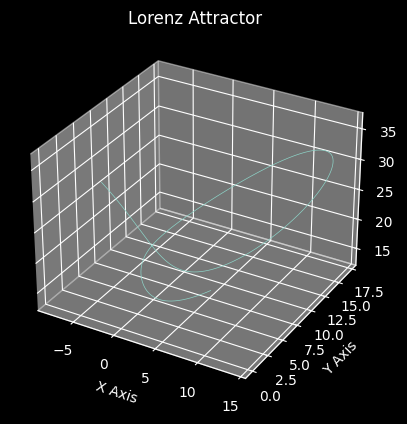

In [34]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*outs.detach().numpy().T,lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

tensor([[-7.8500,  7.1877, 26.1880],
        [-7.6996,  7.3651, 25.3983],
        [-7.5490,  7.5328, 24.6304],
        ...,
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667]], grad_fn=<StackBackward0>)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the network

for epoch in range(epochs):
    for batch, (data, target) in enumerate(train_loader):
        # Obtaining the cuda parameters
        data = data.to(device=device)
        target = target.to(device=device)

        # Reshaping to suit our model
        data = data.reshape(data.shape[0], -1)

        # Forward propagation
        score = model(data)
        loss = criterion(score, target)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [2]:
@jit(nopython=True)
def f(x,t,sigma=10, beta=8/3,rho=28):
    X,Y,Z = x
    return np.array([sigma*(Y-X), X*(rho-Z)-Y, X*Y - (beta*Z)])
@jit(nopython=True)aaaaa
def g(x,t):
    return np.zeros(3)

In [3]:
dt = 0.001
times = np.arange(0,100,dt)
x0=np.array([-8,7,27])
xx1 = integrate(f,g,x0,times,dt,mode="euler")
xx2 = integrate(f,g,x0,times,dt,mode="RK4")

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

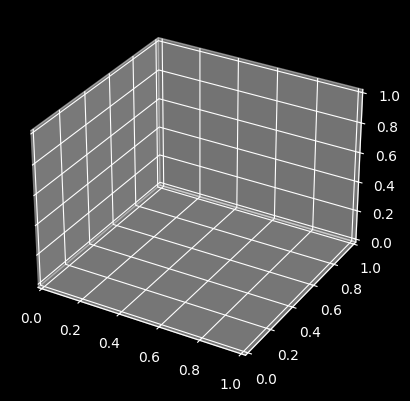

In [9]:
import os 

os.makedirs("data/trajs/lorenz/",exist_ok=True)
np.save("data/trajs/lorenz/1",xx1)